### Testing notebook to prototype exposure custom options

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


## Load packages

In [3]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datacube
from datacube.utils.geometry import Geometry

from intertidal.utils import (
    load_config,
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines
from dea_tools.dask import create_local_dask_cluster

## Temp for tide model testing 17/07/23
from dea_tools.coastal import model_tides, pixel_tides


## Setup
### Set analysis parameters

In [4]:
# Set study area and config
study_area = "pointstuart"
config_path = "configs/dea_intertidal_config_development.yaml"
# study_area = '844'
# config_path='configs/dea_intertidal_config.yaml'

# Intertidal Elevation variables
start_date = "2019"  # Start date for analysis
end_date = "2021"  # End date for analysis
resolution = 100  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition when calculating elevation
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = False  # Filter to remove poorly georeferenced scenes?
tide_model = "FES2014"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models"#"/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
# tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### *Optional: override study area selection using interactive map*

In [5]:
# from odc.ui import select_on_a_map
# from ipyleaflet import basemaps, basemap_to_tiles

# # Plot interactive map to select area
# basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
# geom = select_on_a_map(height='600px',
#                        layers=(basemap,),
#                        center=(-26, 135),
#                        zoom=4)
# study_area = geom

## Intertidal workflow
#### Load data

In [6]:
# Connect to datacube
dc = datacube.Datacube(app="Intertidal_workflow")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    s2_prod="s2_nbart_ndwi" if include_s2 else None,
    ls_prod="ls_nbart_ndwi" if include_ls else None,
    config_path=config_path,
    filter_gqa=filter_gqa)[["ndwi"]]

# Load data and close dask client
satellite_ds.load()
client.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 31,Total memory: 237.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43991,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 31
Started: Just now,Total memory: 237.21 GiB
Comm: tcp://127.0.0.1:35165,Total threads: 31
Dashboard: /user/claire.phillips@ga.gov.au/proxy/37885/status,Memory: 237.21 GiB
Nanny: tcp://127.0.0.1:46461,


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [7]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [8]:
# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    config_path=config_path,
)

2023-07-20 02:02:10 INFO Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2014
Reprojecting tides into original array


100%|██████████| 328/328 [00:00<00:00, 1392.37it/s]
2023-07-20 02:03:10 INFO Masking nodata and adding tide heights to satellite data array
INFO:DEA Intertidal:Masking nodata and adding tide heights to satellite data array
2023-07-20 02:03:10 INFO Flattening satellite data array and filtering to intertidal candidate pixels
INFO:DEA Intertidal:Flattening satellite data array and filtering to intertidal candidate pixels
2023-07-20 02:03:10 INFO Applying valid data mask to constrain study area
INFO:DEA Intertidal:Applying valid data mask to constrain study area
2023-07-20 02:03:11 INFO Running per-pixel rolling median
INFO:DEA Intertidal:Running per-pixel rolling median


Reducing analysed pixels from 759 to 483 (63.64%)


100%|██████████| 114/114 [00:00<00:00, 447.75it/s]
2023-07-20 02:03:11 INFO Modelling intertidal elevation
INFO:DEA Intertidal:Modelling intertidal elevation
2023-07-20 02:03:11 INFO Modelling intertidal uncertainty
INFO:DEA Intertidal:Modelling intertidal uncertainty
2023-07-20 02:03:12 INFO Unflattening data back to its original spatial dimensions
INFO:DEA Intertidal:Unflattening data back to its original spatial dimensions
2023-07-20 02:03:12 INFO Successfully completed intertidal elevation modelling
INFO:DEA Intertidal:Successfully completed intertidal elevation modelling


### Intertidal extents

In [9]:
ds['extents'] = extents(ds_aux.ndwi_wet_freq, ds.elevation, ds_aux.ndwi_tide_corr)

### Intertidal exposure
Calculate exposure using the script function

In [10]:
ds["exposure"], tide_cq, _ = exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2014
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 101/101 [00:00<00:00, 1148.06it/s]


(array([  759.,  3944.,  8686., 10899., 10626.,  9108., 11385., 12144.,
         6831.,  2277.]),
 array([-3.40335377, -2.76607275, -2.12879174, -1.49151073, -0.85422971,
        -0.2169487 ,  0.42033232,  1.05761333,  1.69489434,  2.33217536,
         2.96945637]),
 <BarContainer object of 10 artists>)

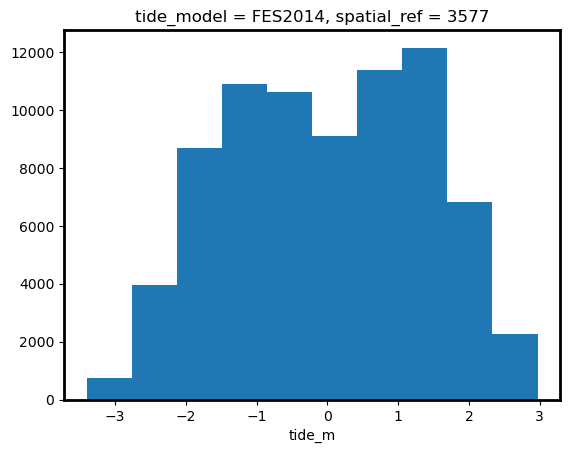

In [11]:
tide_cq.plot()

In [12]:
## Testing updated script

%reload_ext autoreload

ds["exposure_summer"], tide_cq_summer, tiderange_summer = exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    filters = ['summer']
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2014
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 101/101 [00:00<00:00, 1132.56it/s]


In [22]:
## Testing cell

## Bring in the geodata coast 100K polygons to assign local timezones to pixels

import geopandas as gpd
import xarray as xr
from shapely.geometry import Point

In [68]:
## Bring in the state polygons

# nsw = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/new_south_wales/cstnswcd_r.shp')
# nsw

nt = gpd.read_file('../../gdata1/data/boundaries/GEODATA_COAST_100K/northern_territory/cstntcd_r.shp')
# nt

In [58]:
## Transform the coords to common CRS

tidepost_lat = ds.x.median(dim='x')
tidepost_lon = ds.y.median(dim='y')

## Create a transform to convert default epsg3577 coords to epsg4326 for use in sunise/sunset library
# crs_4326 = CRS.from_epsg(4326)
crs_3577 = CRS.from_epsg(3577)
crs_4283 = CRS.from_epsg(4283)

transformer_4326 = Transformer.from_crs(crs_3577, crs_4326)
transformer_4283 = Transformer.from_crs(crs_3577, crs_4283)

## Translate tidepost coords
tidepost_lat, tidepost_lon = transformer_4283.transform(tidepost_lon.values, tidepost_lat.values)

point = Point(tidepost_lat, tidepost_lon)

In [81]:
## Test whether the coords fall within the polygon

## https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
test_ls = []
for x in range(0,len(nt.geometry)):
    polygon = nt.geometry[x]
    test_ls.append(polygon.contains(point))
coords_in_state = test_ls.count(True)
coords_in_state

0

In [ ]:
##TODO: bring in all the state boundaries, assign timezones, enable pixel based
## align with the day/night filtering

In [ ]:
# ## Select the central coordinates to determine timezone
## TODO make tz_aware for day/night only. Test if pixels inside state boundaries
## from GEODATA_COAST_100K to determine timezone.


# ## Locate the central pixel
# tidepost_lat = ds.x.median(dim='x')
# tidepost_lon = ds.y.median(dim='y')

# # ## Extract the central coordinates
# # ds_central = ds.sel(y=[y],x=[x])

# ## Determine the timezone of your area of interest

# '''---------------------------------------------------------'''
# ## Automate timezone selection based on location of tidepost
# ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
# ## Coordinates translated from WGS84 to EPSG 3577 using https://epsg.io/transform#s_srs=4326&t_srs=3857&x=NaN&y=NaN
# if tidepost_lon <= -296731: #129.0:
#     timezone = 'Australia/West'
#     local_tz = 8
# # elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
# elif (tidepost_lon > -296731) & (tidepost_lon <= 593296) & (tidepost_lat < -2818151):
#     timezone = 'Australia/North'
#     local_tz = 9.5
# # elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
# elif (tidepost_lon > -296731) & (tidepost_lon <= 889535) & (tidepost_lat > -2818151):
#     timezone = 'Australia/South'
#     local_tz = 9.5
# # elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
# elif (tidepost_lon > 593296) & (tidepost_lat < -2818151):
#     timezone = 'Australia/Queensland'
#     local_tz = 10
# # elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
# elif (tidepost_lon > 889535) & (tidepost_lat >= -2818151):
#     timezone = 'Australia/NSW'
#     local_tz = 10
# else:
#     print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
# print('Timezone set to', timezone)

# print (timezone, local_tz)

In [50]:
!pip install sunriset

  Using cached sunriset-1.0-py3-none-any.whl (9.6 kB)


In [51]:
import sunriset
from math import ceil
import datetime
from datetime import timedelta
import pytz

from pyproj import CRS
from pyproj import Transformer

import xarray as xr

In [52]:
# %pwd
start_date

'2019'

In [53]:
## Testing sunriset calculations

# Place start and end dates in correct format
start=round_date_strings(start_date, round_type="start")
end=round_date_strings(end_date, round_type="end")
startdate = datetime.date(pd.to_datetime(start).year, pd.to_datetime(start).month, pd.to_datetime(start).day)

# Make the start date timezone aware ##NOTE: temporarily hardcoded for North Australia
time_start = pd.to_datetime(start, utc=True).tz_convert('Australia/North')

# Make 'all_timerange' time-zone aware
localtides = all_timerange.tz_localize(tz=pytz.UTC).tz_convert('Australia/North')

# Replace the UTC datetimes from all_timerange with local times
modelledtides = pd.DataFrame(index = localtides)

# Return the difference in years for the time-period. 
# Round up to ensure all modelledtide datetimes are captured in the solar model
diff = pd.to_datetime(end) - pd.to_datetime(start)
diff = int(ceil(diff.days/365))

## Locate the central pixel for the area of interest
## TODO: work out how to manage this in the pixel-based workflow. Perhaps
## use the same modelling resolution as the underlying tidal model?
tidepost_lat = ds.x.median(dim='x')
tidepost_lon = ds.y.median(dim='y')

## Create a transform to convert default epsg3577 coords to epsg4326 for use in sunise/sunset library
crs_4326 = CRS.from_epsg(4326)
crs_3577 = CRS.from_epsg(3577)

transformer = Transformer.from_crs(crs_3577, crs_4326)

## Translate tidepost coords
tidepost_lat, tidepost_lon = transformer.transform(tidepost_lon.values, tidepost_lat.values)

## Model sunrise and sunset
sun_df = sunriset.to_pandas(startdate, tidepost_lat, tidepost_lon, 9.5, diff)

## Set the index as a datetimeindex to match the modelledtide df
sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))

## Append the date to each Sunrise and Sunset time
sun_df['Sunrise dt'] = sun_df.index + sun_df['Sunrise']
sun_df['Sunset dt'] = sun_df.index + (sun_df['Sunset'])

## Create new dataframes where daytime and nightime datetimes are recorded, then merged on a new `Sunlight` column
daytime=pd.DataFrame(data = 'Sunrise', index=sun_df['Sunrise dt'], columns=['Sunlight'])
nighttime=pd.DataFrame(data = 'Sunset', index=sun_df['Sunset dt'], columns=['Sunlight'])
DayNight = pd.concat([daytime, nighttime], join='outer')
DayNight.sort_index(inplace=True)
DayNight.index.rename('Datetime', inplace=True)

## Create an xarray object from the merged day/night dataframe
day_night = xr.Dataset.from_dataframe(DayNight)

## Remove local timezone timestamp column in modelledtides dataframe. Xarray doesn't handle 
## timezone aware datetimeindexes 'from_dataframe' very well.
modelledtides.index = modelledtides.index.tz_localize(tz=None)

## Create an xr Dataset from the modelledtides pd.dataframe
mt = modelledtides.to_xarray()

## Filter the modelledtides (mt) by the daytime, nighttime datetimes from the sunriset module
## Modelled tides are designated as either day or night by propogation of the last valid index value forward
Solar=day_night.sel(Datetime=mt.index, method='ffill')

## Assign the day and night tideheight datasets
SolarDayTides = mt.where(Solar.Sunlight=='Sunrise', drop=True)
SolarNightTides = mt.where(Solar.Sunlight=='Sunset', drop=True)

## Extract DatetimeIndexes to use in exposure calculations
all_timerange_day = pd.DatetimeIndex(SolarDayTides.index)
all_timerange_night = pd.DatetimeIndex(SolarNightTides.index)

